# SQLAlchemy wrapper around SQLite database

In [63]:
from typing import List
import pandas as pd
from sqlalchemy import (
    create_engine,
    inspect,
    text,
)

class SQLiteDB:
    def __init__(self, db_url: str):
        self.engine = create_engine(db_url)

    def get_table_names(self) -> str:
        inspector = inspect(self.engine)
        tables = inspector.get_table_names()
        return sorted(tables)

    def get_table_schema(self, table_names: List[str]) -> str:
        schema_output = []
        with self.engine.connect() as conn:
            for table in table_names:
                table_info = ""
                # Get CREATE TABLE statement
                result = conn.execute(text(f"SELECT sql FROM sqlite_master WHERE type='table' AND name=:table"), {"table": table}).fetchone()
                if result:
                    table_info += result[0]
                # Get sample rows
                df = pd.read_sql_query(f"SELECT * FROM {table} LIMIT 3", conn)
                table_info += "\n\n/*\n3 rows from {} table:\n{}*/".format(table, df.to_csv(index=False, sep='\t'))
                schema_output.append(table_info)
        return "\n\n\n".join(schema_output)

    def get_random_col_examples(self, table_name: str, col_name: str) -> str:
        with self.engine.connect() as conn:
            df = pd.read_sql_query(
                f"SELECT {col_name} FROM {table_name} ORDER BY RANDOM() LIMIT 10",
                conn
            )
        return df.to_csv(index=False)

In [28]:
db = SQLiteDB("sqlite:///tysql.sqlite")
db.get_table_names()

'Customers, OrderItems, OrderItemsBC, Orders, OrdersBC, Products, Vendors'

# Define Tools

In [64]:
from typing import Type, Optional
from pydantic import BaseModel, Field, ConfigDict
from langchain_core.tools import BaseTool
from langchain_core.callbacks import CallbackManagerForToolRun

class BaseDBTool(BaseModel):
    """Base tool for interacting with a SQL database."""

    db: SQLiteDB = Field(exclude=True)

    model_config = ConfigDict(
        arbitrary_types_allowed=True,
    )

class _ListDBToolInput(BaseModel):
    tool_input: str = Field("", description="An empty string")

class ListDBTool(BaseDBTool, BaseTool):
    """Tool for getting tables names."""

    name: str = "sql_db_list_tables"
    description: str = "Input is an empty string, output is a comma-separated list of tables in the database."
    args_schema: Type[BaseModel] = _ListDBToolInput

    def _run(
        self,
        tool_input: str = "",
        run_manager: Optional[CallbackManagerForToolRun] = None,
    ) -> str:
        """Get a comma-separated list of table names."""
        return ", ".join(self.db.get_table_names())

class _SchemaDBToolInput(BaseModel):
    table_names: str = Field(
        ..., description=(
            "A comma-separated list of the table names for which to return the schema. "
            "Example input: 'table1, table2, table3'"
        ),
    )

class SchemaDBTool(BaseDBTool, BaseTool):
    name: str = "sql_db_schema"
    description: str = "Get the schema and sample rows for the specified SQL tables."
    args_schema: Type[BaseModel] = _SchemaDBToolInput
    db: SQLiteDB

    def _run(self, table_names: str, run_manager: Optional[CallbackManagerForToolRun] = None) -> str:
        return self.db.get_table_schema([t.strip() for t in table_names.split(",")])

class _ExamplesDBToolInput(BaseModel):
    table_name: str = Field(..., description="The table name the column is located in.")
    column_name: str = Field(..., description="A column name to generate 10 random examples of.")

class ExamplesDBTool(BaseDBTool, BaseTool):
    name: str = "sql_db_random_column_values"
    description: str = "Get 10 random values for a specified column in a table."
    args_schema: Type[BaseModel] = _ExamplesDBToolInput
    db: SQLiteDB

    def _run(self, table_name: str, column_name: str, run_manager: Optional[CallbackManagerForToolRun] = None) -> str:
        return self.db.get_random_col_examples(table_name, column_name)

# Create Toolkit

In [65]:
from langchain_core.tools import BaseToolkit
from pydantic import ConfigDict

class SQLiteMetadataToolkit(BaseToolkit):
    db: SQLiteDB
    model_config = ConfigDict(arbitrary_types_allowed=True)

    def get_tools(self):
        list_db_tool = ListDBTool(db=self.db)

        schema_db_tool_description = (
            "Input to this tool is a comma-separated list of tables, output is the "
            "schema and sample rows for those tables. "
            "Be sure that the tables actually exist by calling "
            f"{list_db_tool.name} first! "
            "Example Input: table1, table2, table3"
        )
        schema_db_tool = SchemaDBTool(
            db=self.db, description=schema_db_tool_description
        )

        examples_db_tool_description = (
            "Input to this tool is a table name and a column name. "
            "Be sure the column name exists by calling "
            f"{schema_db_tool.name} first!"
        )
        examples_db_tool = ExamplesDBTool(
            db=self.db, description=examples_db_tool_description
        )

        return [
            list_db_tool,
            schema_db_tool,
            examples_db_tool
        ]

# Create Agent

In [66]:
# -------------------------------- INSTANTIATE LLM --------------------------------
import getpass
import os
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI

load_dotenv()
if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")


# llm = init_chat_model("anthropic:claude-3-5-sonnet-latest")

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

In [91]:
from langgraph.prebuilt import create_react_agent

db = SQLiteDB("sqlite:///Monthly_Prescription_Drug_Plan_Formulary_and_Pharmacy_Network_Information.db")
toolkit = SQLiteMetadataToolkit(db=db)
tools = toolkit.get_tools()

from langchain_core.prompts import ChatPromptTemplate
system_prompt = """You are a metadata assistant for SQLite databases.

You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.

Given an input prompt, generate table metadata. You must:
1. Describe the table in one sentence.
2. Describe each column, including type and purpose, using real field values.
3. Identify primary and foreign key columns using names and context.
in the following strict JSON format.

OUTPUT FORMAT:
{
  "table_name": "<name of the table>",
  "table_description": "<brief description of the table>",
  "table_columns": {
      "<column_name>": "<description of the column with data type, format, and context>",
      ...
  },
  "table_key_columns": {
      "<column_name>": "<description of how it's used as a key>"
      ...
  }
}

Use double quotes and valid JSON formatting. Do not include Python-style comments or markdown.
Avoid guessing data types solely from the SQL schema. Use sample values and patterns to infer types.
Example formats: "TEXT field for two-letter U.S. state abbreviation", "Birthday in mm/dd/yyyy format", etc.

You MUST use the available tools to inspect the schema and sample data for any table before generating your final answer. Do NOT guess the structure or contents of the table. Do not answer until you have called the necessary tools and seen their outputs.
To start you should ALWAYS look at the tables in the database to see what you can query.
Do NOT skip this step.
Then you should query the schema of the most relevant tables. DO NOT TRUST THE SCHEMA DATA TYPES. The schema is sometimes faulty as it could've been generated programatically.
AlWAYS query example values for **ALL COLUMNS** to find the actual datatypes of EACH COLUMN. If you feel like you did not have enough variety of data for a column's example values, retry the query as it returns random values!
To find foreign keys, you must also check OTHER tables to see where columns names of the queried table are shared in other tables.
"""

sql_agent = create_react_agent(llm, tools, prompt=system_prompt)


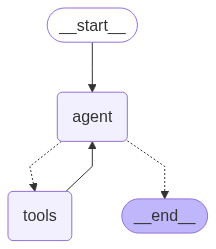

In [55]:
from IPython.display import Image, display
display(Image(sql_agent.get_graph().draw_mermaid_png()))

# Invoke Agent (and stream ouput)

In [92]:
query = 'Generate metadata for the InsulineBeneficiaryCost table. This table comes from a database for Medicare Prescription Drug Plans and Medicare Advantage (MA) Prescription Drug Plans.'

# sql_agent.invoke({"messages": [('user', query)]})

# for event in sql_agent.stream(
#     {"messages": [('user', query)]},
#     stream_mode='values'
# ):
#     event['messages'][-1].pretty_print()

prev_len = 0
for event in sql_agent.stream(
    {"messages": [('user', query)]},
    stream_mode='values'
):
    new_messages = event['messages'][prev_len:]
    for message in new_messages:
        message.pretty_print()
    prev_len = len(event['messages'])

================================ Human Message =================================

Generate metadata for the InsulineBeneficiaryCost table. This table comes from a database for Medicare Prescription Drug Plans and Medicare Advantage (MA) Prescription Drug Plans.
================================== Ai Message ==================================

Okay, I will get the metadata for the InsulineBeneficiaryCost table.
First, I need to check what tables are available in the database.
Tool Calls:
  sql_db_list_tables (122963f9-8c84-4a26-9b72-631be4601af2)
 Call ID: 122963f9-8c84-4a26-9b72-631be4601af2
  Args:
    tool_input:
================================= Tool Message =================================
Name: sql_db_list_tables

BasicDrugFormulary, BeneficiaryCost, ExcludedDrugsFormulary, GeographicLocator, IndicationBasedCoverageFormulary, InsulinBeneficiaryCost, PharmacyNetworks, PlanInformation
================================== Ai Message ==================================
Tool Calls:
  sql_